In [ ]:
pip install flask requests beautifulsoup4 pandas matplotlib seaborn nltk scikit-learn

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (classification_report, confusion_matrix, 
                           roc_auc_score, precision_recall_curve, auc,
                           mean_absolute_error, accuracy_score)
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')


import matplotlib.font_manager as fm
import platform
plt.rcParams['font.family'] = 'Malgun Gothic'

In [3]:
#%% ==================================================
# Task 1: 환경 설정 및 데이터 로드
#%% ==================================================

print("=" * 50)
print("Task 1: 환경 설정 및 데이터 로드")
print("=" * 50)

# 데이터 로드
df = pd.read_csv('dart_final.csv')

print(f"데이터 shape: {df.shape}")
print(f"기업 수: {df['corp_name'].nunique()}")
print(f"기간: {df['year'].min()} ~ {df['year'].max()}")

# 분기 정렬
from pandas import CategoricalDtype
qcat = CategoricalDtype(categories=['Q1','Q2','Q3','Q4'], ordered=True)
df['quarter'] = df['quarter'].astype(qcat)
df = df.sort_values(['corp_name','year','quarter']).reset_index(drop=True)

# 7개 재무지표 정의
feature_cols = ['부채비율', '자기자본비율', 'ROA', 'ROE', 
                '매출액성장률', '영업이익성장률', '순이익성장률']

# 결측치 처리
for col in feature_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')

print(f"사용할 X변수 (7개): {feature_cols}")
print("Task 1 완료\n")


Task 1: 환경 설정 및 데이터 로드
데이터 shape: (1140, 16)
기업 수: 32
기간: 2016 ~ 2025
사용할 X변수 (7개): ['부채비율', '자기자본비율', 'ROA', 'ROE', '매출액성장률', '영업이익성장률', '순이익성장률']
Task 1 완료



In [10]:
#%% ==================================================
# Task 2: 위험 플래그 계산
#%% ==================================================

print("=" * 50)
print("Task 2: 위험 플래그 계산")
print("=" * 50)

g = df.groupby('corp_name', group_keys=False)

# 위험 플래그 계산
df['완전자본잠식'] = (df['자본총계'] < 0).astype(int)
df['연속매출감소'] = g['매출액성장률'].transform(
    lambda s: (s < 0).astype('int8').rolling(3, min_periods=2).sum()
).ge(2).astype(int)
df['고부채비율'] = (df['부채비율'] >= 200).astype(int)
df['영업손실연속'] = g['영업이익'].transform(
    lambda s: (s < 0).astype('int8').rolling(4, min_periods=3).sum()
).eq(2).astype(int)
df['ROA악화'] = (df['ROA'] < -5).astype(int)
df['자기자본부족'] = (df['자기자본비율'] < 20).astype(int)
df['매출급감'] = (df['매출액성장률'] < -30).astype(int)
df['영업이익성장률악화'] = g['영업이익성장률'].transform(
    lambda s: (s < 0).astype('int8').rolling(3, min_periods=2).sum()
).ge(2).astype(int)

risk_flags = ['완전자본잠식', '연속매출감소', '고부채비율', '영업손실연속', 
              'ROA악화', '자기자본부족', '매출급감', '영업이익성장률악화']

print("위험 플래그 분포:")
for flag in risk_flags:
    count = df[flag].sum()
    print(f"  {flag}: {count}개 ({count/len(df)*100:.1f}%)")

print("Task 2 완료\n")

Task 2: 위험 플래그 계산
위험 플래그 분포:
  완전자본잠식: 6개 (0.5%)
  연속매출감소: 512개 (44.9%)
  고부채비율: 451개 (39.6%)
  영업손실연속: 76개 (6.7%)
  ROA악화: 25개 (2.2%)
  자기자본부족: 114개 (10.0%)
  매출급감: 75개 (6.6%)
  영업이익성장률악화: 626개 (54.9%)
Task 2 완료



In [32]:
#%% ==================================================
# Task 3: 휴리스틱 위험점수 계산
#%% ==================================================


import numpy as np
import pandas as pd

# --- (안전) 숫자형 보정 ---
df['자산총계'] = pd.to_numeric(df['자산총계'], errors='coerce')
df['부채비율'] = pd.to_numeric(df['부채비율'], errors='coerce')
df['자기자본비율'] = pd.to_numeric(df['자기자본비율'], errors='coerce')
df['ROA'] = pd.to_numeric(df['ROA'], errors='coerce')
df['ROE'] = pd.to_numeric(df['ROE'], errors='coerce')
df['매출액성장률'] = pd.to_numeric(df['매출액성장률'], errors='coerce')
df['영업이익성장률'] = pd.to_numeric(df['영업이익성장률'], errors='coerce')
df['순이익성장률'] = pd.to_numeric(df['순이익성장률'], errors='coerce')

# --- 1) 플래그 기반 점수 (그대로) ---
risk_weights = {
    '완전자본잠식': 10, 'ROA악화': 6, '영업손실연속': 5, '고부채비율': 4,
    '연속매출감소': 3, '자기자본부족': 3, '매출급감': 2, '영업이익성장률악화': 1
}
df['flag_score'] = 0
for flag in risk_flags:
    df['flag_score'] += df[flag] * risk_weights.get(flag, 1)

# --- 2) 기업 규모 분류 (자산총계 기준) ---
# 10조 이상: 대기업, 1조~10조: 중견기업, 1조 미만: 중소기업
bins = [-np.inf, 1e12, 1e13, np.inf]
labels = ['중소기업', '중견기업', '대기업']
df['company_size'] = pd.cut(df['자산총계'], bins=bins, labels=labels, right=False)

# --- 3) 재무비율 점수(상대평가, 0~10) ---
def calculate_relative_score(series, reverse=False):
    pr = series.rank(pct=True)  # NaN은 뒤에서 자동 처리됨
    score = pr * 10 if reverse else (1 - pr) * 10
    return score.fillna(score.mean())  # NaN 방지(선택)

df['debt_score_base'] = calculate_relative_score(df['부채비율'].clip(0, 500), reverse=True)
df['equity_score'] = calculate_relative_score(df['자기자본비율'].clip(0, 100), reverse=False)
df['roa_score'] = calculate_relative_score(df['ROA'].clip(-50, 50), reverse=False)
df['roe_score'] = calculate_relative_score(df['ROE'].clip(-100, 100), reverse=False)
df['sales_growth_score'] = calculate_relative_score(df['매출액성장률'].clip(-100, 200), reverse=False)
df['profit_growth_score'] = calculate_relative_score(df['영업이익성장률'].clip(-200, 500), reverse=False)
df['net_growth_score'] = calculate_relative_score(df['순이익성장률'].clip(-500, 1000), reverse=False)

# --- 3-1) 기업규모별 부채비율 가중치 적용 ---
# 대기업 0.5배, 중견 0.75배, 중소 1.0배
df['debt_weight'] = df['company_size'].map({'대기업':0.5, '중견기업':0.75, '중소기업':1.0}).astype(float).fillna(1.0)
df['debt_score'] = df['debt_score_base'].astype(float) * df['debt_weight']

# --- 4) 휴리스틱 가중치 & 최종 점수 ---
heuristic_weights = {
    'flag_score': 0.4,
    'debt_score': 0.15,
    'equity_score': 0.10,
    'roa_score': 0.15,
    'roe_score': 0.05,
    'sales_growth_score': 0.08,
    'profit_growth_score': 0.05,
    'net_growth_score': 0.02
}

df['heuristic_score'] = (
    df['flag_score'] * heuristic_weights['flag_score'] +
    df['debt_score'] * heuristic_weights['debt_score'] +
    df['equity_score'] * heuristic_weights['equity_score'] +
    df['roa_score'] * heuristic_weights['roa_score'] +
    df['roe_score'] * heuristic_weights['roe_score'] +
    df['sales_growth_score'] * heuristic_weights['sales_growth_score'] +
    df['profit_growth_score'] * heuristic_weights['profit_growth_score'] +
    df['net_growth_score'] * heuristic_weights['net_growth_score']
) * 10  # 0~100 스케일

def assign_heuristic_label(score):
    if score <= 20: return 0  # 안전
    elif score <= 40: return 1  # 주의
    elif score <= 65: return 2  # 위험
    else: return 3  # 매우위험

df['heuristic_label'] = df['heuristic_score'].apply(assign_heuristic_label)
df['heuristic_label_name'] = df['heuristic_label'].map({0:'안전',1:'주의',2:'위험',3:'매우위험'})

# --- 체크 출력 ---
print("기업 규모별 분포:")
print(df['company_size'].value_counts(dropna=False))

print("\n부채비율 가중치 예시(상위 5개):")
print(df[['corp_name','year','quarter','자산총계','company_size','부채비율','debt_score_base','debt_weight','debt_score']].head())

print("\n휴리스틱 점수 분포:")
print(df['heuristic_score'].describe())

print("\n휴리스틱 라벨 분포:")
print(df['heuristic_label_name'].value_counts())


기업 규모별 분포:
company_size
중견기업    546
중소기업    443
대기업     151
Name: count, dtype: int64

부채비율 가중치 예시(상위 5개):
  corp_name  year quarter          자산총계 company_size        부채비율  \
0     DL이앤씨  2016      Q2  1.237828e+13          대기업  144.953291   
1     DL이앤씨  2016      Q3  1.218542e+13          대기업  136.935499   
2     DL이앤씨  2016      Q4  1.239151e+13          대기업  140.828150   
3     DL이앤씨  2017      Q1  1.281212e+13          대기업  144.126142   
4     DL이앤씨  2017      Q2  1.320628e+13          대기업  145.128425   

   debt_score_base  debt_weight  debt_score  
0         4.587719          0.5    2.293860  
1         4.315789          0.5    2.157895  
2         4.429825          0.5    2.214912  
3         4.535088          0.5    2.267544  
4         4.614035          0.5    2.307018  

휴리스틱 점수 분포:
count    1140.000000
mean       46.107941
std        22.986821
min         2.977193
25%        29.383224
50%        43.342654
75%        60.455318
max       137.082456
Name: heuristic_score, dtyp

In [28]:
#%% ==================================================
# Task 4: 시계열 데이터 준비 및 예측
#%% ==================================================

print("=" * 50)
print("Task 4: 시계열 데이터 준비 및 예측")
print("=" * 50)

# 다음 분기 라벨 생성
df_sorted = df.sort_values(['corp_name', 'year', 'quarter']).reset_index(drop=True)
df_sorted['next_heuristic_label'] = df_sorted.groupby('corp_name')['heuristic_label'].shift(-1)
df_sorted['next_heuristic_score'] = df_sorted.groupby('corp_name')['heuristic_score'].shift(-1)

# 평가 가능한 데이터
eval_df = df_sorted[df_sorted['next_heuristic_label'].notna()].copy()

print(f"전체 데이터: {len(df_sorted)}개")
print(f"평가 가능 데이터: {len(eval_df)}개")

# 현재 분기 점수로 다음 분기 예측 (단순 휴리스틱)
eval_df['predicted_next_score'] = eval_df['heuristic_score']  # 현재 점수 = 다음 분기 예측
eval_df['predicted_next_label'] = eval_df['predicted_next_score'].apply(assign_heuristic_label)

print("Task 4 완료\n")

Task 4: 시계열 데이터 준비 및 예측
전체 데이터: 1140개
평가 가능 데이터: 1108개
Task 4 완료



In [29]:

#%% ==================================================
# Task 5: 다양한 평가 지표 계산
#%% ==================================================

print("=" * 50)
print("Task 5: 다양한 평가 지표 계산")
print("=" * 50)

y_true = eval_df['next_heuristic_label'].astype(int)
y_pred = eval_df['predicted_next_label'].astype(int)
y_score = eval_df['predicted_next_score']
y_true_score = eval_df['next_heuristic_score']

# 1) 기본 분류 지표
accuracy = accuracy_score(y_true, y_pred)
print(f"정확도: {accuracy:.3f}")

# 2) MAE (평균 절대 오차)
mae = mean_absolute_error(y_true_score, y_score)
print(f"MAE (점수): {mae:.3f}")

# 3) MAPE (평균 절대 백분율 오차)
mape = np.mean(np.abs((y_true_score - y_score) / (y_true_score + 1e-8))) * 100
print(f"MAPE: {mape:.1f}%")

# 4) Direction Accuracy (방향 정확도)
# 위험도 증감 방향 예측 정확도
prev_score = eval_df.groupby('corp_name')['heuristic_score'].shift(1)
actual_change = eval_df['next_heuristic_score'] - eval_df['heuristic_score']
predicted_change = eval_df['predicted_next_score'] - eval_df['heuristic_score']

valid_idx = (prev_score.notna()) & (actual_change != 0)
if valid_idx.sum() > 0:
    direction_acc = np.mean(
        np.sign(actual_change[valid_idx]) == np.sign(predicted_change[valid_idx])
    )
    print(f"Direction Accuracy: {direction_acc:.3f}")

# 5) ROC-AUC (이진 분류로 변환)
# 위험 vs 안전으로 이진화
y_true_binary = (y_true >= 2).astype(int)  # 위험(2,3) vs 안전(0,1)
y_score_binary = y_score

if len(np.unique(y_true_binary)) > 1:
    roc_auc = roc_auc_score(y_true_binary, y_score_binary)
    print(f"ROC-AUC (위험 vs 안전): {roc_auc:.3f}")

# 6) Precision-Recall AUC
precision, recall, _ = precision_recall_curve(y_true_binary, y_score_binary)
pr_auc = auc(recall, precision)
print(f"PR-AUC (위험 탐지): {pr_auc:.3f}")

print("Task 5 완료\n")

Task 5: 다양한 평가 지표 계산
정확도: 0.473
MAE (점수): 14.730
MAPE: 43.0%
Direction Accuracy: 0.000
ROC-AUC (위험 vs 안전): 0.844
PR-AUC (위험 탐지): 0.884
Task 5 완료



In [30]:
#%% ==================================================
# Task 6: 혼동 행렬 및 상세 분석
#%% ==================================================

print("=" * 50)
print("Task 6: 혼동 행렬 및 상세 분석")
print("=" * 50)

# 혼동 행렬
cm = confusion_matrix(y_true, y_pred)
cm_df = pd.DataFrame(cm, 
                     index=[f'실제_{name}' for name in label_names.values()],
                     columns=[f'예측_{name}' for name in label_names.values()])
print("혼동 행렬:")
print(cm_df)

# 클래스별 상세 분석
print(f"\n분류 리포트:")
print(classification_report(y_true, y_pred, target_names=list(label_names.values())))

# 위험 탐지 성능 (위험 이상 클래스 기준)
high_risk_true = (y_true >= 2).astype(int)
high_risk_pred = (y_pred >= 2).astype(int)

if high_risk_true.sum() > 0:
    high_risk_precision = (high_risk_true & high_risk_pred).sum() / (high_risk_pred.sum() + 1e-8)
    high_risk_recall = (high_risk_true & high_risk_pred).sum() / high_risk_true.sum()
    high_risk_f1 = 2 * high_risk_precision * high_risk_recall / (high_risk_precision + high_risk_recall + 1e-8)
    
    print(f"\n위험 기업 탐지 성능:")
    print(f"  Precision: {high_risk_precision:.3f}")
    print(f"  Recall: {high_risk_recall:.3f}")
    print(f"  F1-Score: {high_risk_f1:.3f}")

print("Task 6 완료\n")


Task 6: 혼동 행렬 및 상세 분석
혼동 행렬:
         예측_안전  예측_주의  예측_위험  예측_매우위험
실제_안전       38     73     29        0
실제_주의       82    170     88        7
실제_위험       26     90    192       89
실제_매우위험      0     13     87      124

분류 리포트:
              precision    recall  f1-score   support

          안전       0.26      0.27      0.27       140
          주의       0.49      0.49      0.49       347
          위험       0.48      0.48      0.48       397
        매우위험       0.56      0.55      0.56       224

    accuracy                           0.47      1108
   macro avg       0.45      0.45      0.45      1108
weighted avg       0.47      0.47      0.47      1108


위험 기업 탐지 성능:
  Precision: 0.799
  Recall: 0.792
  F1-Score: 0.795
Task 6 완료



In [31]:
#%% ==================================================
# Task 7: 결과 분석 및 랭킹
#%% ==================================================

print("=" * 50)
print("Task 7: 결과 분석 및 랭킹")
print("=" * 50)

# 최신 분기 위험 기업 TOP 15
latest_data = df_sorted.groupby('corp_name').last().reset_index()
high_risk_companies = latest_data.nlargest(15, 'heuristic_score')[
    ['corp_name', 'year', 'quarter', 'heuristic_score', 'heuristic_label_name', 'flag_score']
]

print("=== 위험도 높은 기업 TOP 15 ===")
print(high_risk_companies)

# 안전한 기업 TOP 10
safe_companies = latest_data.nsmallest(10, 'heuristic_score')[
    ['corp_name', 'heuristic_score', 'heuristic_label_name', 'flag_score']
]

print(f"\n=== 안전한 기업 TOP 10 ===")
print(safe_companies)

# 특정 기업 시계열 추이
sample_company = df_sorted['corp_name'].iloc[0]
company_trend = df_sorted[df_sorted['corp_name'] == sample_company][
    ['year', 'quarter', 'heuristic_score', 'heuristic_label_name', 'flag_score']
].tail(8)

print(f"\n=== {sample_company} 위험도 추이 (최근 8분기) ===")
print(company_trend)

print("Task 7 완료\n")

Task 7: 결과 분석 및 랭킹
=== 위험도 높은 기업 TOP 15 ===
   corp_name  year quarter  heuristic_score heuristic_label_name  flag_score
16      삼부토건  2025      Q2       103.539912                 매우위험          19
14      동부건설  2025      Q2        94.956140                 매우위험          13
23      이수화학  2025      Q2        93.425877                 매우위험          12
26    코오롱글로벌  2025      Q2        89.274123                 매우위험          12
27      태영건설  2025      Q2        86.956031                 매우위험          10
13        대원  2025      Q2        80.014912                 매우위험          11
3      HJ중공업  2025      Q2        75.164803                 매우위험           8
29      한신공영  2025      Q2        67.144737                 매우위험           8
7     경동인베스트  2025      Q2        66.139474                 매우위험           9
9       금호건설  2025      Q2        59.872697                   위험           7
1       GS건설  2025      Q2        52.577632                   위험           4
6      KCC건설  2025      Q2      

Task 8: 시각화


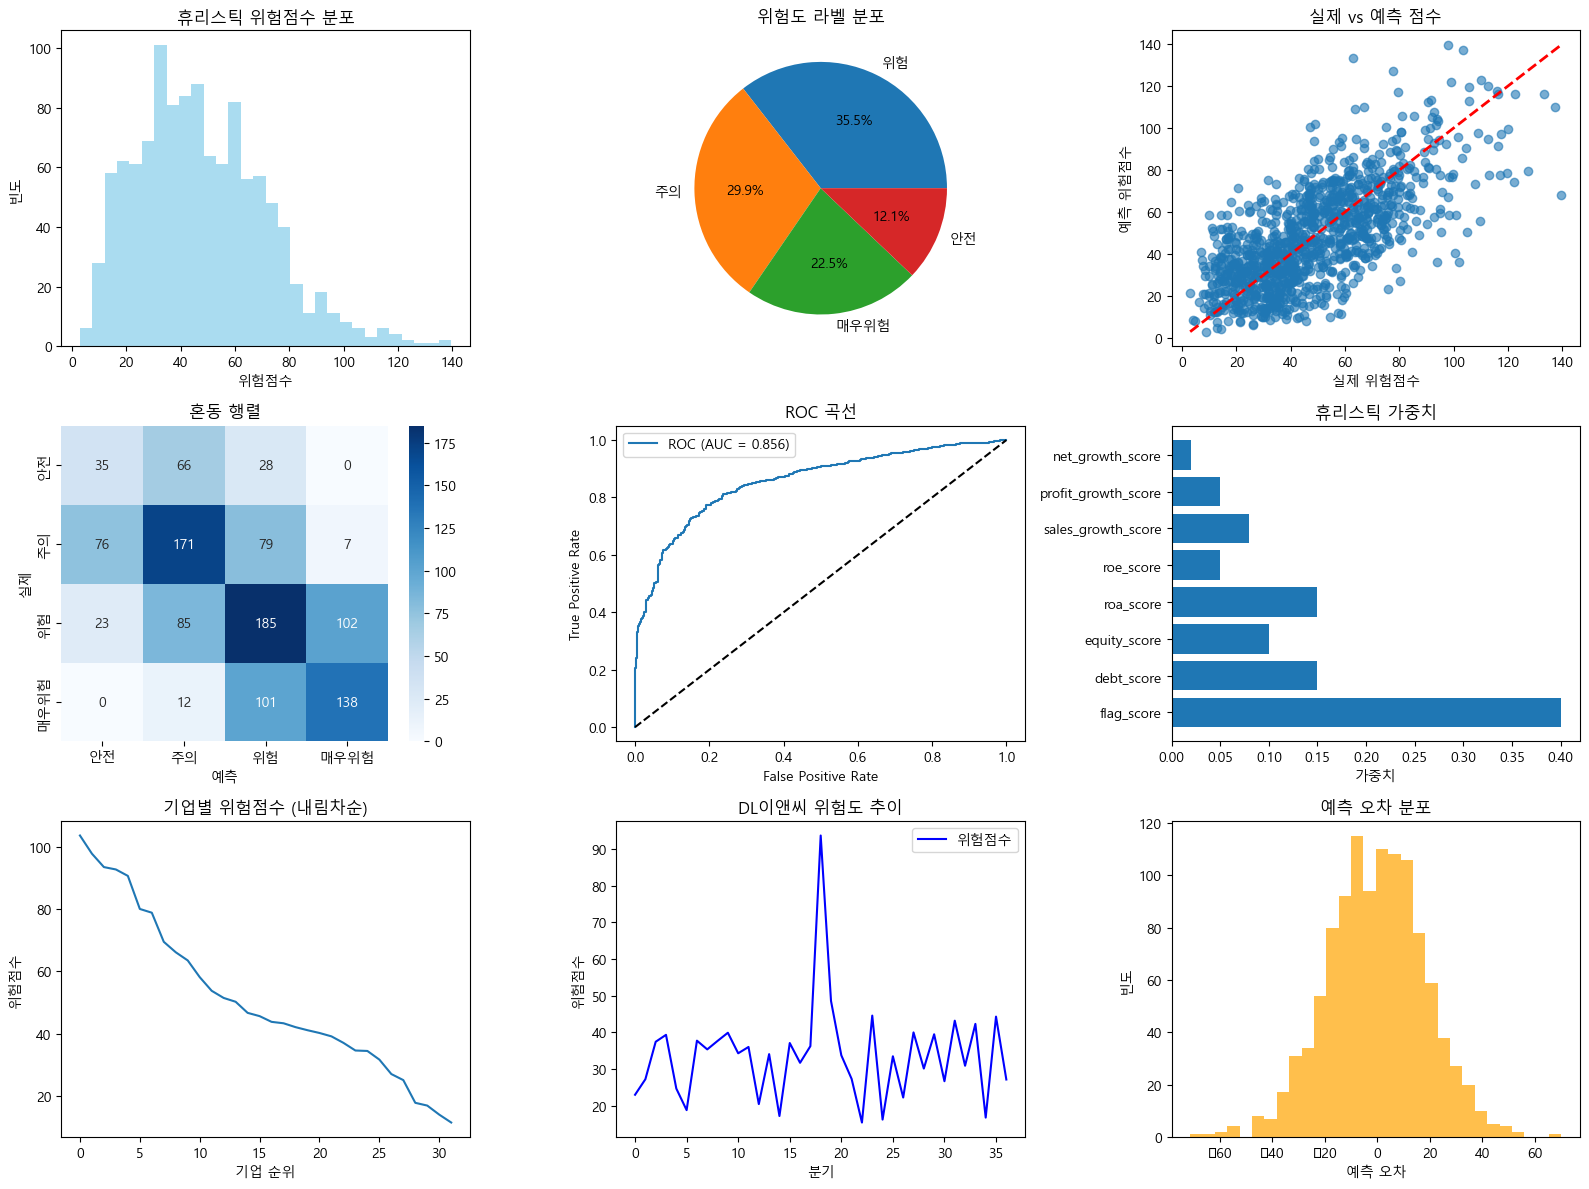

Task 8 완료



In [24]:
#%% ==================================================
# Task 8: 시각화
#%% ==================================================

print("=" * 50)
print("Task 8: 시각화")
print("=" * 50)

plt.figure(figsize=(16, 12))

# 1) 휴리스틱 점수 분포
plt.subplot(3, 3, 1)
plt.hist(df_sorted['heuristic_score'], bins=30, alpha=0.7, color='skyblue')
plt.title('휴리스틱 위험점수 분포')
plt.xlabel('위험점수')
plt.ylabel('빈도')

# 2) 라벨 분포
plt.subplot(3, 3, 2)
label_counts = df_sorted['heuristic_label_name'].value_counts()
plt.pie(label_counts.values, labels=label_counts.index, autopct='%1.1f%%')
plt.title('위험도 라벨 분포')

# 3) 실제 vs 예측 산점도
plt.subplot(3, 3, 3)
plt.scatter(y_true_score, y_score, alpha=0.6)
plt.plot([y_true_score.min(), y_true_score.max()], 
         [y_true_score.min(), y_true_score.max()], 'r--', lw=2)
plt.xlabel('실제 위험점수')
plt.ylabel('예측 위험점수')
plt.title('실제 vs 예측 점수')

# 4) 혼동 행렬 히트맵
plt.subplot(3, 3, 4)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_names.values(),
            yticklabels=label_names.values())
plt.title('혼동 행렬')
plt.xlabel('예측')
plt.ylabel('실제')

# 5) ROC 곡선
if len(np.unique(y_true_binary)) > 1:
    from sklearn.metrics import roc_curve
    fpr, tpr, _ = roc_curve(y_true_binary, y_score_binary)
    
    plt.subplot(3, 3, 5)
    plt.plot(fpr, tpr, label=f'ROC (AUC = {roc_auc:.3f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC 곡선')
    plt.legend()

# 6) 가중치 시각화
plt.subplot(3, 3, 6)
weights = list(heuristic_weights.values())
labels = list(heuristic_weights.keys())
plt.barh(range(len(labels)), weights)
plt.yticks(range(len(labels)), labels)
plt.title('휴리스틱 가중치')
plt.xlabel('가중치')

# 7) 기업별 최신 위험도
plt.subplot(3, 3, 7)
latest_scores = latest_data['heuristic_score'].sort_values(ascending=False)
plt.plot(range(len(latest_scores)), latest_scores)
plt.title('기업별 위험점수 (내림차순)')
plt.xlabel('기업 순위')
plt.ylabel('위험점수')

# 8) 시계열 추이
plt.subplot(3, 3, 8)
company_data = df_sorted[df_sorted['corp_name'] == sample_company]
plt.plot(company_data['heuristic_score'].values, 'b-', label='위험점수')
plt.title(f'{sample_company} 위험도 추이')
plt.xlabel('분기')
plt.ylabel('위험점수')
plt.legend()

# 9) 예측 오차 분포
plt.subplot(3, 3, 9)
errors = y_score - y_true_score
plt.hist(errors, bins=30, alpha=0.7, color='orange')
plt.title('예측 오차 분포')
plt.xlabel('예측 오차')
plt.ylabel('빈도')

plt.tight_layout()
plt.show()

print("Task 8 완료\n")

In [ ]:
#%% ==================================================
# Task 9: 결과 저장
#%% ==================================================

print("=" * 50)
print("Task 9: 결과 저장")
print("=" * 50)

# 결과 저장
result_df = df_sorted[[
    'corp_name', 'year', 'quarter',
    'predicted_risk_score', 'risk_score_100', 'predicted_risk_class', 'predicted_risk_name',
    'risk_label', 'risk_label_name', '위험점수'
] + feature_cols + risk_flags].copy()

result_df.to_csv('construction_linear_model_results.csv', index=False, encoding='utf-8-sig')

print(f"결과가 'construction_linear_model_results.csv'에 저장되었습니다.")
print(f"총 {len(result_df)}개 관측치 분석 완료")

# 최종 모델 요약
print(f"\n=== 최종 모델 요약 ===")
print(f"선형회귀 수식:")
print(f"{equation}")
print(f"선형회귀 R²: {r2:.3f}")
print(f"로지스틱회귀 정확도: {accuracy:.3f}")
print(f"학습 데이터 크기: {len(train_df)}")
print(f"예측 가능한 기업: {df_sorted['corp_name'].nunique()}개")

print("\nTask 9 완료: 모든 분석 완료!")
print("=" * 50)